In [1]:
%load_ext autotime

In [2]:
# Importar librerias
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import numpy as np

import zipfile
from datetime import date
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report


from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

from numpy.testing import assert_allclose

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, GlobalMaxPool1D, Conv1D, Flatten,  MaxPooling1D, Activation, GlobalMaxPooling1D, Bidirectional, GRU
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from sklearn.decomposition import PCA

import os
from pathlib import Path


time: 2.83 s


In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

time: 1.5 ms


In [4]:
exp_name = '7_C'
folder = 'Resultados/' + exp_name
my_file = Path(folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(folder)
    


already exists
time: 177 ms


In [5]:
ch_folder = folder + '/Checkpoints'
my_file = Path(ch_folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(ch_folder)

already exists
time: 97.9 ms


### Read datasets

In [6]:
#Importar los datasets
url_embeddings_average_individual = zipfile.ZipFile('../Data/sum_topics.zip')

embeddings_average_individual = pd.read_csv(url_embeddings_average_individual.open('sum_topics.csv'))


embeddings_average_individual['Date'] =  pd.to_datetime(embeddings_average_individual['Date'], format='%Y-%m-%d')
embeddings_average_individual.sort_values('Date', inplace=True)

embeddings_average_individual.reset_index()
embeddings_average_individual.fillna(0, inplace=True)

n_pc = 3

time: 4.32 s


In [7]:
#embeddings_average_individual= embeddings_average_individual.drop(list(map(str, range(0, 300))), axis = 1)
embeddings_average_individual.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
49650,-0.258057,0.055664,-0.115906,0.234863,-0.313477,-0.229248,-0.310059,-0.937866,0.203003,0.082031,0.329590,-0.594727,-0.261230,0.403076,-0.385742,-0.096497,-0.145752,0.237793,0.144287,-0.175148,0.281189,-0.389648,0.484558,0.013672,-0.670044,0.123779,-0.199829,-0.436523,0.048401,0.183594,0.318436,-0.038940,-0.228760,-0.281738,-0.228043,0.239136,-0.112305,-0.213867,0.698975,0.353271,0.328308,-0.015869,0.832031,0.217529,-0.078613,-0.142578,-0.202026,0.013550,0.061218,0.618652,-0.275391,0.182007,0.280396,0.302490,-0.465576,-0.339355,-0.695312,-0.036865,0.404053,-0.281738,-0.027588,0.327637,-0.825439,0.327423,-0.248535,-0.402832,-0.592773,-0.267578,-0.565018,0.037292,-0.114990,0.431519,-0.108398,0.574432,-0.851562,-0.138763,0.311768,0.054688,-0.187439,-0.066284,0.209839,-0.267090,-0.481445,-0.300110,-0.277466,-0.432129,-0.587402,0.077637,0.050781,0.252930,0.315674,0.123535,-0.776367,-0.557098,0.103516,0.483154,0.260620,0.376160,0.638306,0.986328,-0.373093,0.019897,0.391479,-0.322021,0.295990,-0.312866,-0.869629,-0.454102,0.456055,-0.264496,0.426880,-0.137451,0.107422,0.191406,0.108398,-0.028809,0.057617,0.105957,0.108398,0.493164,-0.234985,0.404297,-0.385742,0.074463,1.004395,-0.280029,-0.436523,-0.438904,0.290527,0.266602,-0.253540,-0.022827,0.304382,0.025391,-0.058228,0.016541,0.055664,-0.156265,-0.451172,0.034912,-0.089355,-0.754395,-0.276855,0.501465,-0.333496,0.098755,0.018555,-0.033569,0.116943,-0.671875,1.583504,-0.754883,-0.025146,0.285645,-0.026917,-0.535889,0.098206,0.599854,-0.015625,-0.144287,0.193726,0.200195,0.182922,-0.533951,-0.299133,0.013428,0.681641,-0.178619,0.488281,0.606445,-0.443573,0.505371,-0.325684,-0.482910,-0.018433,0.029480,1.098633,-0.079346,-0.238770,0.270264,-0.903320,-0.242188,-0.070435,-1.223145,-0.221191,-0.625732,-0.186142,0.000000,0.273682,-0.068115,0.105553,0.395508,0.645020,-0.189453,0.056641,0.313721,-0.559570,0.174561,-0.647705,-0.745117,0.041260,0.552856,0.130981,-0.513550,-0.107666,0.055573,-0.132080,-1.150879,-0.062378,0.181885,-0.403442,-0.019287,-0.468384,0.393311,-0.334717,0.044189,0.203369,-0.232910,-0.618652,-0.156982,0.359863,-0.232666,0.709473,-0.321289,-0.165527,-0.463867,0.076904,-0.081543,0.094757,0.157959,0.127258,-0.415039,0.185791,-0.010254,-0.418457,-0.280029,0.126465,-0.240967,0.640564,-0.163635,-0.126953,0.456543,-0.292938,0.212646,-0.594727,1.074707,0.055054,0.012695,-0.213867,-0.138794,0.852051,-0.023926,0.450684,0.403076,0.361084,-0.089752,0.354492,-0.213623,0.581955,-0.482666,-0.010254,-0.242920,-0.009033,0.281250,-0.127441,0.358154,0.014893,-0.362549,-0.072266,-0.917969,-0.123184,0.562500,-0.146729,-0.232422,0.429688,0.103760,-0.323242,-0.191406,-0.320312,0.141617,-0.324951,-0.458740,0.090210,0.647705,-0.433105,-0.286011,-0.431885,-0.086792,0.141357,0.180603,-0.018555,0.161865,-0.108765,-0.041992,0.32

time: 243 ms


### Embedding Promedio

In [8]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end = pd.to_datetime("2013-12-31")
num_training = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end])

time: 45.9 ms


In [9]:
# Selecciono el archivo con el que se corre el modelo
data = embeddings_average_individual[embeddings_average_individual['Date']<='2014-12-31']
print(data['Label'].mean())
data.head(1)

0.5418076004775169


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
49650,-0.258057,0.055664,-0.115906,0.234863,-0.313477,-0.229248,-0.310059,-0.937866,0.203003,0.082031,0.32959,-0.594727,-0.26123,0.403076,-0.385742,-0.096497,-0.145752,0.237793,0.144287,-0.175148,0.281189,-0.389648,0.484558,0.013672,-0.670044,0.123779,-0.199829,-0.436523,0.048401,0.183594,0.318436,-0.03894,-0.22876,-0.281738,-0.228043,0.239136,-0.112305,-0.213867,0.698975,0.353271,0.328308,-0.015869,0.832031,0.217529,-0.078613,-0.142578,-0.202026,0.01355,0.061218,0.618652,-0.275391,0.182007,0.280396,0.30249,-0.465576,-0.339355,-0.695312,-0.036865,0.404053,-0.281738,-0.027588,0.327637,-0.825439,0.327423,-0.248535,-0.402832,-0.592773,-0.267578,-0.565018,0.037292,-0.11499,0.431519,-0.108398,0.574432,-0.851562,-0.138763,0.311768,0.054688,-0.187439,-0.066284,0.209839,-0.26709,-0.481445,-0.30011,-0.277466,-0.432129,-0.587402,0.077637,0.050781,0.25293,0.315674,0.123535,-0.776367,-0.557098,0.103516,0.483154,0.26062,0.37616,0.638306,0.986328,-0.373093,0.019897,0.391479,-0.322021,0.29599,-0.312866,-0.869629,-0.454102,0.456055,-0.264496,0.42688,-0.137451,0.107422,0.191406,0.108398,-0.028809,0.057617,0.105957,0.108398,0.493164,-0.234985,0.404297,-0.385742,0.074463,1.004395,-0.280029,-0.436523,-0.438904,0.290527,0.266602,-0.25354,-0.022827,0.304382,0.025391,-0.058228,0.016541,0.055664,-0.156265,-0.451172,0.034912,-0.089355,-0.754395,-0.276855,0.501465,-0.333496,0.098755,0.018555,-0.033569,0.116943,-0.671875,1.583504,-0.754883,-0.025146,0.285645,-0.026917,-0.535889,0.098206,0.599854,-0.015625,-0.144287,0.193726,0.200195,0.182922,-0.533951,-0.299133,0.013428,0.681641,-0.178619,0.488281,0.606445,-0.443573,0.505371,-0.325684,-0.48291,-0.018433,0.02948,1.098633,-0.079346,-0.23877,0.270264,-0.90332,-0.242188,-0.070435,-1.223145,-0.221191,-0.625732,-0.186142,0.0,0.273682,-0.068115,0.105553,0.395508,0.64502,-0.189453,0.056641,0.313721,-0.55957,0.174561,-0.647705,-0.745117,0.04126,0.552856,0.130981,-0.51355,-0.107666,0.055573,-0.13208,-1.150879,-0.062378,0.181885,-0.403442,-0.019287,-0.468384,0.393311,-0.334717,0.044189,0.203369,-0.23291,-0.618652,-0.156982,0.359863,-0.232666,0.709473,-0.321289,-0.165527,-0.463867,0.076904,-0.081543,0.094757,0.157959,0.127258,-0.415039,0.185791,-0.010254,-0.418457,-0.280029,0.126465,-0.240967,0.640564,-0.163635,-0.126953,0.456543,-0.292938,0.212646,-0.594727,1.074707,0.055054,0.012695,-0.213867,-0.138794,0.852051,-0.023926,0.450684,0.403076,0.361084,-0.089752,0.354492,-0.213623,0.581955,-0.482666,-0.010254,-0.24292,-0.009033,0.28125,-0.127441,0.358154,0.014893,-0.362549,-0.072266,-0.917969,-0.123184,0.5625,-0.146729,-0.232422,0.429688,0.10376,-0.323242,-0.191406,-0.320312,0.141617,-0.324951,-0.45874,0.09021,0.647705,-0.433105,-0.286011,-0.431885,-0.086792,0.141357,0.180603,-0.018555,0.161865,-0.108765,-0.041992,0.325134,0.161133,-0.435913,0.135132,0.11

time: 312 ms


In [10]:
training = data[:num_training]
testing = data[num_training:]

# Se separa en train y test
x_train = data.drop(["Top","Label", "Date"], axis=1)[:num_training]
x_test = data.drop(["Top",'Label', 'Date'], axis=1)[num_training:]
y_train = data["Label"].values[:num_training]
y_test = data["Label"].values[num_training:]


x_train_array = x_train.to_numpy()
reshape_x_train = x_train_array.reshape(len(x_train), 1, x_train.shape[1])
reshape_x_train.shape

x_test_array = x_test.to_numpy()
reshape_x_test = x_test_array.reshape(len(x_test), 1, x_train.shape[1])
reshape_x_test.shape

(6294, 1, 310)

time: 68.4 ms


In [11]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_params = {'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 34,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}
best_bayes_params

{'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 34,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}

time: 200 ms


In [12]:

model = Sequential()
model.add(LSTM(best_bayes_params['units1'], input_shape=(1,x_train.shape[1]), return_sequences=True))
model.add(Dropout(best_bayes_params['dropout1']))
model.add(LSTM(best_bayes_params['units2'], return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# define the checkpoint
filepath= ch_folder + "/word2vec-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

time: 637 ms


In [13]:

logdir = "Resultados\\" + exp_name +"\\logs\\model"


tensor_board = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = 100000000)


time: 1.55 ms


In [14]:
# fit the model
model.fit(reshape_x_train, y_train,
          epochs=best_bayes_params['nb_epochs'], 
          batch_size=best_bayes_params['batch_size'], callbacks=[tensor_board])


model.save(folder + '/keras_model.h5')
model.summary()

Epoch 1/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6903 - accuracy: 0.5397
Epoch 2/34
67/67 [==============================] - 2s 26ms/step - loss: 0.6897 - accuracy: 0.5400
Epoch 3/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6887 - accuracy: 0.5419
Epoch 4/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6867 - accuracy: 0.5451
Epoch 5/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6834 - accuracy: 0.5551
Epoch 6/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6791 - accuracy: 0.5627
Epoch 7/34
67/67 [==============================] - 2s 25ms/step - loss: 0.6737 - accuracy: 0.5764
Epoch 8/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6681 - accuracy: 0.5867
Epoch 9/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6609 - accuracy: 0.5976
Epoch 10/34
67/67 [==============================] - 2s 24ms/step - loss: 0.6528 - accuracy: 0.6152
Epoch 11/

In [15]:
# evaluate the model
ypred = model.predict_proba(reshape_x_test)
len(ypred)

Instructions for updating:
Please use `model.predict()` instead.


6294

time: 1.14 s


In [16]:
testing_cp = testing.copy()
testing_cp['Prob'] = ypred

testing_cp['Prediction'] = 0
names = []
for i in range(10):
    names.append('topic_' + str(i))
topics = testing_cp.loc[:,names]
testing_cp['topic_highest']=topics.idxmax(axis=1)
testing_cp.loc[testing_cp['Prob']> 0.5, 'Prediction'] = 1
tops = {}
total = 0
for i in range(25):
    grupo = testing_cp.loc[testing_cp['Top'] == i +1 ,['Label', 'Prediction']  ]
    tops[str(i +1) ] = accuracy_score(grupo.Label, grupo.Prediction)
topics_acc = {}
for j in names:
    grupo_2 = testing_cp.loc[testing_cp['topic_highest'] == j ,['Label', 'Prediction'] ]
    topics_acc[j] = accuracy_score(grupo_2.Label, grupo_2.Prediction)

time: 186 ms


In [17]:
testing_cp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Prob,Prediction,topic_highest
15719,0.405273,0.241211,0.623291,0.838379,0.079102,-0.112305,0.372894,-1.167297,1.251465,0.989258,-0.850952,-0.918457,0.069092,-0.058105,-0.564575,0.734131,0.163025,0.842041,0.035287,-0.441406,0.208008,0.377228,-0.057587,-0.395508,-0.330089,0.304710,-0.991211,0.278076,0.655640,-0.442871,0.488831,0.118896,-0.843994,-0.373047,0.903564,-0.087074,-0.576294,0.318726,0.621094,0.876221,-0.385376,-0.039825,0.291138,1.045898,-0.206909,0.812012,0.550871,-0.232101,-0.756348,1.375122,-0.518677,0.407715,-0.656372,0.217407,0.197388,-0.163879,0.009033,-0.648865,-0.076172,-0.479980,-0.407715,1.119324,0.208496,0.219162,0.008057,-0.052399,-0.341309,0.066345,-0.483444,-0.003357,-0.950623,1.114487,1.087646,0.321045,-0.574165,-0.651367,-0.215027,0.511658,0.497681,0.252441,-0.721680,-0.156494,0.457642,-0.393555,0.040100,-0.408691,-0.480057,-0.100342,-0.205338,0.723572,0.774536,-0.715820,-0.790283,-0.440918,-0.794800,-0.245728,0.137787,-0.474609,1.666016,-0.733643,-0.349121,0.916992,0.607300,0.025452,-1.218262,0.394897,-1.120117,-0.313934,0.040466,-0.110229,-0.315430,-0.283936,-1.161621,0.323242,0.259033,0.432129,-1.012207,-0.623535,0.608643,0.482880,-0.739258,0.797852,-0.824463,0.480225,-0.475098,-0.380798,0.504883,-0.529053,-0.061035,0.275330,-0.024780,0.223572,-0.637695,0.564697,-0.198547,-1.570557,-0.222137,0.289307,-0.328125,0.224823,0.160583,-0.829102,0.122559,0.336792,0.402679,-0.842651,1.006592,-0.113281,0.178711,-0.232574,1.174316,-0.569336,0.051422,-0.071289,-0.552429,-1.145020,-0.233398,0.155273,0.286621,-0.578857,-0.592773,-0.279755,0.280739,-0.947266,0.301636,-1.101074,0.704834,-0.129700,-0.290222,0.834229,-0.542664,-0.175781,0.836487,-1.041016,0.287109,-0.048828,0.565613,-0.326416,-0.447510,-0.650391,-1.361328,-0.756226,0.595093,-1.430664,0.269775,0.830322,-0.694313,0.539673,0.613586,1.302002,0.287109,0.400887,-0.025452,-0.225342,-0.503906,0.431641,-0.364746,0.461426,-0.226501,-2.309570,-0.390259,0.412109,0.234619,-1.060181,0.134033,0.368164,0.234131,-0.022217,-0.534668,0.323471,-1.192871,0.285645,-0.936295,0.381836,-0.822021,-0.107361,-0.406738,-0.364746,-0.432495,0.628662,0.097778,-0.458496,0.834862,-0.049194,-0.625000,0.074463,0.362061,-0.668701,0.537476,-0.164169,-0.571777,0.190018,1.098145,-0.583839,0.987305,0.797318,-0.007568,-0.135742,0.290466,-0.843140,0.441299,-0.391113,0.261963,-0.371582,0.254639,0.306610,-0.207004,-0.551758,-0.538971,-0.740051,0.817383,0.022297,0.307373,0.487061,0.119263,-1.339111,0.348511,-0.778137,0.568573,-0.710205,0.120605,-0.035645,-0.023453,0.194076,0.501587,0.822632,-1.185547,-0.005127,-0.478516,-0.236816,0.055908,0.864502,0.288940,-0.248047,0.262024,-0.086052,-0.918091,-0.099243,-0.648682,0.834473,-0.640030,0.188721,-0.347107,0.118164,-0.429077,-0.512451,-0.800537,0.381836,0.385498,0.044373,-0.789673,-0.2965

time: 243 ms


### Definir datasets de testeo

In [18]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end_real = pd.to_datetime("2014-12-31")
num_training_real = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end_real])

time: 42.9 ms


In [19]:
# Selecciono el archivo con el que se corre el modelo
data_real = embeddings_average_individual
data_real.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
49650,-0.258057,0.055664,-0.115906,0.234863,-0.313477,-0.229248,-0.310059,-0.937866,0.203003,0.082031,0.32959,-0.594727,-0.26123,0.403076,-0.385742,-0.096497,-0.145752,0.237793,0.144287,-0.175148,0.281189,-0.389648,0.484558,0.013672,-0.670044,0.123779,-0.199829,-0.436523,0.048401,0.183594,0.318436,-0.03894,-0.22876,-0.281738,-0.228043,0.239136,-0.112305,-0.213867,0.698975,0.353271,0.328308,-0.015869,0.832031,0.217529,-0.078613,-0.142578,-0.202026,0.01355,0.061218,0.618652,-0.275391,0.182007,0.280396,0.30249,-0.465576,-0.339355,-0.695312,-0.036865,0.404053,-0.281738,-0.027588,0.327637,-0.825439,0.327423,-0.248535,-0.402832,-0.592773,-0.267578,-0.565018,0.037292,-0.11499,0.431519,-0.108398,0.574432,-0.851562,-0.138763,0.311768,0.054688,-0.187439,-0.066284,0.209839,-0.26709,-0.481445,-0.30011,-0.277466,-0.432129,-0.587402,0.077637,0.050781,0.25293,0.315674,0.123535,-0.776367,-0.557098,0.103516,0.483154,0.26062,0.37616,0.638306,0.986328,-0.373093,0.019897,0.391479,-0.322021,0.29599,-0.312866,-0.869629,-0.454102,0.456055,-0.264496,0.42688,-0.137451,0.107422,0.191406,0.108398,-0.028809,0.057617,0.105957,0.108398,0.493164,-0.234985,0.404297,-0.385742,0.074463,1.004395,-0.280029,-0.436523,-0.438904,0.290527,0.266602,-0.25354,-0.022827,0.304382,0.025391,-0.058228,0.016541,0.055664,-0.156265,-0.451172,0.034912,-0.089355,-0.754395,-0.276855,0.501465,-0.333496,0.098755,0.018555,-0.033569,0.116943,-0.671875,1.583504,-0.754883,-0.025146,0.285645,-0.026917,-0.535889,0.098206,0.599854,-0.015625,-0.144287,0.193726,0.200195,0.182922,-0.533951,-0.299133,0.013428,0.681641,-0.178619,0.488281,0.606445,-0.443573,0.505371,-0.325684,-0.48291,-0.018433,0.02948,1.098633,-0.079346,-0.23877,0.270264,-0.90332,-0.242188,-0.070435,-1.223145,-0.221191,-0.625732,-0.186142,0.0,0.273682,-0.068115,0.105553,0.395508,0.64502,-0.189453,0.056641,0.313721,-0.55957,0.174561,-0.647705,-0.745117,0.04126,0.552856,0.130981,-0.51355,-0.107666,0.055573,-0.13208,-1.150879,-0.062378,0.181885,-0.403442,-0.019287,-0.468384,0.393311,-0.334717,0.044189,0.203369,-0.23291,-0.618652,-0.156982,0.359863,-0.232666,0.709473,-0.321289,-0.165527,-0.463867,0.076904,-0.081543,0.094757,0.157959,0.127258,-0.415039,0.185791,-0.010254,-0.418457,-0.280029,0.126465,-0.240967,0.640564,-0.163635,-0.126953,0.456543,-0.292938,0.212646,-0.594727,1.074707,0.055054,0.012695,-0.213867,-0.138794,0.852051,-0.023926,0.450684,0.403076,0.361084,-0.089752,0.354492,-0.213623,0.581955,-0.482666,-0.010254,-0.24292,-0.009033,0.28125,-0.127441,0.358154,0.014893,-0.362549,-0.072266,-0.917969,-0.123184,0.5625,-0.146729,-0.232422,0.429688,0.10376,-0.323242,-0.191406,-0.320312,0.141617,-0.324951,-0.45874,0.09021,0.647705,-0.433105,-0.286011,-0.431885,-0.086792,0.141357,0.180603,-0.018555,0.161865,-0.108765,-0.041992,0.325134,0.161133,-0.435913,0.135132,0.11

time: 259 ms


In [20]:
training_real = data_real[:num_training_real]
testing_real = data_real[num_training_real:]

# Se separa en train y test
x_train_real = data_real.drop(["Top","Label", "Date"], axis=1)[:num_training_real]
x_test_real = data_real.drop(["Top",'Label', 'Date'], axis=1)[num_training_real:]
y_train_real = data_real["Label"].values[:num_training_real]
y_test_real = data_real["Label"].values[num_training_real:]


x_train_array_real = x_train_real.to_numpy()
reshape_x_train_real = x_train_array_real.reshape(len(x_train_real), 1, x_train_real.shape[1])
reshape_x_train_real.shape

x_test_array_real = x_test_real.to_numpy()
reshape_x_test_real = x_test_array_real.reshape(len(x_test_real), 1, x_train_real.shape[1])
reshape_x_test_real.shape

(9443, 1, 310)

time: 77.4 ms


In [21]:

model_real = Sequential()
model_real.add(LSTM(best_bayes_params['units1'], input_shape=(1,x_train_real.shape[1]), return_sequences=True))
model_real.add(Dropout(best_bayes_params['dropout1']))
model_real.add(LSTM(best_bayes_params['units2'], return_sequences=False))
model_real.add(Dense(1, activation='sigmoid'))
# compile the model
model_real.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# define the checkpoint
filepath= ch_folder + "/word2vec-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

time: 678 ms


In [22]:

logdir = "Resultados\\" + exp_name +"\\logs\\model"


tensor_board = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch = 100000000)


time: 1.46 ms


In [23]:
# fit the model
model_real.fit(reshape_x_train_real, y_train_real,
          epochs=best_bayes_params['nb_epochs'], 
          batch_size=best_bayes_params['batch_size'], callbacks=[tensor_board])


model_real.save(folder + '/keras_model.h5')
model_real.summary()

Epoch 1/34
79/79 [==============================] - 2s 28ms/step - loss: 0.6900 - accuracy: 0.5411
Epoch 2/34
79/79 [==============================] - 3s 37ms/step - loss: 0.6890 - accuracy: 0.5418
Epoch 3/34
79/79 [==============================] - 2s 28ms/step - loss: 0.6874 - accuracy: 0.5442
Epoch 4/34
79/79 [==============================] - 2s 28ms/step - loss: 0.6854 - accuracy: 0.5524
Epoch 5/34
79/79 [==============================] - 2s 32ms/step - loss: 0.6819 - accuracy: 0.5603
Epoch 6/34
79/79 [==============================] - 2s 27ms/step - loss: 0.6772 - accuracy: 0.5693
Epoch 7/34
79/79 [==============================] - 2s 24ms/step - loss: 0.6729 - accuracy: 0.5794
Epoch 8/34
79/79 [==============================] - 2s 24ms/step - loss: 0.6661 - accuracy: 0.5895
Epoch 9/34
79/79 [==============================] - 2s 24ms/step - loss: 0.6595 - accuracy: 0.5976
Epoch 10/34
79/79 [==============================] - 2s 24ms/step - loss: 0.6525 - accuracy: 0.6097
Epoch 11/

In [24]:
ypred_real_train = model_real.predict_proba(reshape_x_train_real)
len(ypred_real_train)

40208

time: 4.25 s


In [25]:
train_cp_real = training_real.copy()
train_cp_real['Prob'] = ypred_real_train
topics_train_real = train_cp_real.loc[:,names]
train_cp_real['topic_highest']=topics_train_real.idxmax(axis=1)
train_cp_real['score_top'] = train_cp_real.apply(lambda x: tops[str(x.Top)], axis=1)
train_cp_real['score_topic'] = train_cp_real.apply(lambda x: topics_acc[x.topic_highest], axis=1)
train_cp_real['full_score'] = train_cp_real['score_topic']* train_cp_real['score_top'] 
train_cp_real['score_dia'] = train_cp_real['full_score'].groupby(train_cp_real['Date']).transform('sum')
train_cp_real['score_norm'] = train_cp_real['full_score']/train_cp_real['score_dia']
train_cp_real['prob_norm'] =train_cp_real['score_norm'] *  train_cp_real['Prob']
train_cp_real['prob_dia'] = train_cp_real['prob_norm'].groupby(train_cp_real['Date']).transform('sum')
train_cp_real['Prediction_dia'] = 0
train_cp_real.loc[train_cp_real['Prob']> 0.5, 'Prediction_dia'] = 1
accuracy_score(train_cp_real.Label, train_cp_real.Prediction_dia)

0.7986221647433347

time: 4.83 s


In [26]:
prueba_train = train_cp_real.drop_duplicates(subset = ['Date'])
prueba_train[['Date', 'Label', 'Prediction_dia']].to_csv('results_train.csv', index=False)

time: 63.2 ms


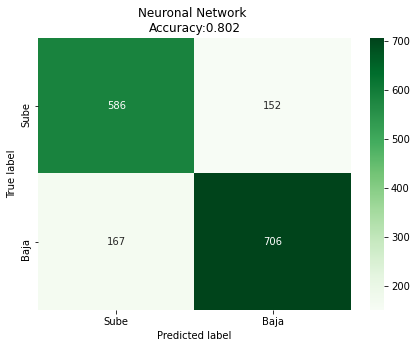

time: 369 ms


In [27]:

# Creates a confusion matrix
cm = confusion_matrix(prueba_train.Label, prueba_train.Prediction_dia) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Sube','Baja'], 
                     columns = ['Sube','Baja'])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="Greens", fmt='g')
plt.title('Neuronal Network \nAccuracy:{0:.3f}'.format(accuracy_score(prueba_train.Label, prueba_train.Prediction_dia)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [28]:
# evaluate the model
ypred_real = model_real.predict_proba(reshape_x_test_real)
len(ypred_real)

9443

time: 816 ms


In [39]:
testing_cp_real = testing_real.copy()
testing_cp_real['Prob'] = ypred_real
topics_real = testing_cp_real.loc[:,names]
testing_cp_real['topic_highest']=topics_real.idxmax(axis=1)
testing_cp_real['score_top'] = testing_cp_real.apply(lambda x: tops[str(x.Top)], axis=1)
testing_cp_real['score_topic'] = testing_cp_real.apply(lambda x: topics_acc[x.topic_highest], axis=1)
testing_cp_real['full_score'] = testing_cp_real['score_topic']* testing_cp_real['score_top'] 
testing_cp_real['score_dia'] = testing_cp_real['full_score'].groupby(testing_cp_real['Date']).transform('sum')
testing_cp_real['score_norm'] = testing_cp_real['full_score']/testing_cp_real['score_dia']
testing_cp_real['prob_norm'] = testing_cp_real['score_norm'] *  testing_cp_real['Prob']
testing_cp_real['prob_dia'] = testing_cp_real['prob_norm'].groupby(testing_cp_real['Date']).transform('sum')
testing_cp_real['Prediction_dia'] = 0
testing_cp_real.loc[testing_cp_real['prob_dia']> 0.5, 'Prediction_dia'] = 1
accuracy_score(testing_cp_real.Label, testing_cp_real.Prediction_dia)

0.5450598326802922

time: 1.02 s


In [41]:
prueba = testing_cp_real.drop_duplicates(subset = ['Date'])
prueba[['Date', 'Label','Prediction_dia']].to_csv('results_test.csv', index=False)

time: 18.8 ms


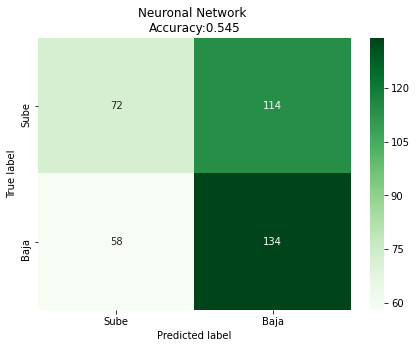

time: 259 ms


In [42]:

# Creates a confusion matrix
cm = confusion_matrix(prueba.Label, prueba.Prediction_dia) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Sube','Baja'], 
                     columns = ['Sube','Baja'])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="Greens", fmt='g')
plt.title('Neuronal Network \nAccuracy:{0:.3f}'.format(accuracy_score(prueba.Label, prueba.Prediction_dia)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
